# for place cells on the central arm, current method for determining which trial they pop up is inaccurate, which might make the co-popping up in accurate. Let's first examine how inaccurate.

In [1]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf
import pingouin as pg
import trial_correlates as tc
import tqdm
import misc

import switch_analysis_one_session as saos
reload(saos)

reload(misc)

from collections import OrderedDict

from scipy.spatial.distance import pdist, squareform, dice

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
db_sorted = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
ii=0
data_dir_full = db_sorted['data_dir_full'][ii]
ani = db_sorted.index[ii][0]#'e15_13f1'#'e13_26m1'
sess=db_sorted['sess_name'][ii]#'e15_13f1_220117'#'e13_26m1_210913'
print(sess)

e13_26m1_210913


In [3]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [4]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [5]:
# for fr_map; not necessarily needed, only when we need to visualize things

In [5]:
# load data
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

In [6]:
import place_field_analysis as pf
reload(pf)
reload(pa)

<module 'place_cell_analysis' from '/mnt/home/szheng/projects/util_code/place_cell_analysis.py'>

In [7]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


reload(pa)
fr_map_concat,index_within_to_trial_index_df = pa.concat_fr_map_trial_df_d(fr_map_trial_df_d,spk_beh_df)

cant format into a dataframe
cant format into a dataframe


In [22]:
index_within_to_trial_index_df

        index
0  0.0  0         1
        1         3
        2         6
        3         8
        4        10
                 ..
   1.0  32       62
        33       64
        34       66
        35       67
        36       69
Name: 0, Length: 70, dtype: int64

# seperate fields on the central arm and side arms; first focus on fields that are mostly on the central arm, vs the rest;
for those fields, change_df will have all the trials; for the rest, changes_df seperate into two
- so only need: select these fields, do change detection for all trials for these fields, for the existing change_df, pick out the rest of the fields 
- then coswitching / correlation: is it same left right for the common fields?
- to get a final similarity matrix, for comparisons within the central arm fields, use all trials; for comparisons between central arm and side arm fields, or side vs side, only use the common trials; 
- so the change df can have all trials as columns; if for a field it does not fire in that trial, then mask it with nan
- the final concatenation: max similarity among all fields
- still interesting to also keep multiple fields and see the range of their similarities

- first, distribution of proportion on the central arm

In [9]:
central_arm_bounds_cm = np.array([0,74])
bin_width = 2.2
central_arm_bounds_bin = (central_arm_bounds_cm // bin_width).astype(int)

In [10]:
all_fields_all_trialtype=pd.concat(pf_res['avg']['all_fields'],axis=0)

In [11]:
width_within_bound=np.minimum(all_fields_all_trialtype['end'],central_arm_bounds_bin[1]) - np.maximum(all_fields_all_trialtype['start'],central_arm_bounds_bin[0])
width_within_bound.loc[width_within_bound<0] = 0
width = all_fields_all_trialtype['end'] - all_fields_all_trialtype['start']
width_within_bound_ratio = width_within_bound / width


[Text(0, 0.5, 'Fraction among all fields'),
 Text(0.5, 0, 'width on central arm / total width')]

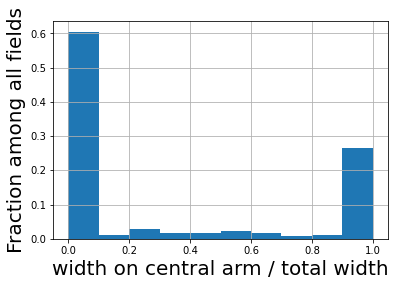

In [12]:
%matplotlib inline
ax=width_within_bound_ratio.hist(weights = np.ones_like(width_within_bound_ratio.index) / len(width_within_bound_ratio.index))
ax.set(ylabel='Fraction among all fields',xlabel='width on central arm / total width')



In [14]:
width_within_bound_ratio

             field_index
0  0.0  3    0                0.5625
        27   0                   1.0
        29   0                   1.0
             1              0.722222
             2                   0.0
                              ...   
   1.0  468  0                   0.0
        474  0                   0.0
             1                   0.0
        475  0              0.409091
        476  0                  0.45
Length: 762, dtype: object

In [106]:
dist.astype(int).idxmax()

0

In [12]:
# find fields whose coms are similar in left and right trials
left_right_similar_fields = {}
index_other = []
task_ind = 0
trial_type_ind = 0
trial_type_to_compare_ind = 1
similar_thresh_in_bin = 5
for (ni,fi),row in all_fields_all_trialtype.loc[task_ind,trial_type_ind].iterrows():
    if ni in all_fields_all_trialtype.loc[task_ind,trial_type_to_compare_ind].index:
        dist = np.abs(row['com'] - all_fields_all_trialtype.loc[task_ind,trial_type_to_compare_ind].loc[ni]['com'] )
        if dist.min() < similar_thresh_in_bin:
            left_right_similar_fields[ni,fi] = row
            fi_other = dist.astype(int).idxmin()
            index_other.append([ni,fi_other])
index_other = np.array(index_other)
left_right_similar_fields = pd.DataFrame(left_right_similar_fields).T

left_right_similar_fields['other_field_index'] = index_other[:,1]
    

In [15]:
left_right_similar_fields

,,start,end,com,peak,fr_peak,fr_mean,other_field_index
3,0,24,40,32,32,2.329971,1.259748,0
29,1,20,38,29,30,22.516135,14.113698,1
30,0,1,21,8,6,10.134196,6.402575,0
33,0,16,42,30,29,10.58372,6.379726,0
34,1,41,52,46,43,4.130213,3.356445,0
...,...,...,...,...,...,...,...,...
454,0,30,43,36,37,3.964734,2.631886,0
455,0,1,11,5,6,1.657099,1.311049,0
456,0,30,46,38,40,14.696264,8.662157,0
475,0,24,42,33,36,5.028874,3.177112,0


In [13]:
# among these left_right_similar_fields, find the awkward fields, that are not fully within the central arm
awkward_ratio_lims = (0.2,0.9)
width_within_bound_ratio_sub = width_within_bound_ratio.loc[(width_within_bound_ratio > awkward_ratio_lims[0]) & (width_within_bound_ratio < awkward_ratio_lims[1])]
awkward_fields = left_right_similar_fields.loc[width_within_bound_ratio_sub.loc[0,0].index.intersection(left_right_similar_fields.index)]



In [18]:
awkward_fields

,,start,end,com,peak,fr_peak,fr_mean,other_field_index
3,0,24,40,32,32,2.329971,1.259748,0
29,1,20,38,29,30,22.516135,14.113698,1
33,0,16,42,30,29,10.58372,6.379726,0
43,1,25,41,33,33,14.046127,9.353755,1
62,1,18,48,32,31,23.254106,18.306253,1
68,1,27,47,36,32,6.80527,5.586382,1
94,1,24,39,31,34,6.2079,5.352104,0
107,0,22,41,32,37,4.338125,2.971711,0
126,0,23,39,31,31,17.48335,12.371299,0
127,0,25,40,32,31,6.778184,5.238486,0


In [15]:
# combine those fields with similar left and right com, then look at fr differences across two trialtypes


left_right_similar_fields


,,start,end,com,peak,fr_peak,fr_mean,other_field_index
3,0,24,40,32,32,2.329971,1.259748,0
29,1,20,38,29,30,22.516135,14.113698,1
30,0,1,21,8,6,10.134196,6.402575,0
33,0,16,42,30,29,10.58372,6.379726,0
34,1,41,52,46,43,4.130213,3.356445,0
...,...,...,...,...,...,...,...,...
454,0,30,43,36,37,3.964734,2.631886,0
455,0,1,11,5,6,1.657099,1.311049,0
456,0,30,46,38,40,14.696264,8.662157,0
475,0,24,42,33,36,5.028874,3.177112,0


In [14]:
pf_fr = pd.concat(pf_res['avg']['params'],axis=0).loc[(slice(None),slice(None),'fr_mean'),:]
index=pf_fr.index.droplevel(2)
pf_fr.index=index

In [40]:
pf_fr

0          1          2          3          4          5   \
0 0.0 3   0   0.361854   1.660383   0.895757   0.000000   0.469987   0.000000   
      27  0  14.497671  13.804467  23.114017  20.660537  24.060318  18.031251   
      29  0   5.357048   8.640619  11.218283   9.660357   6.298226  16.213038   
          1   9.346967   7.827861  16.289806  15.501734   6.856234  12.040284   
          2   3.397325  16.521741  12.426897   7.661892   9.691956   6.869698   
...                ...        ...        ...        ...        ...        ...   
  1.0 468 0   0.000000   0.202885   2.316181   3.014935   2.374491   2.322661   
      474 0   1.330156   0.634764   0.278320   0.741663   1.024034   0.228785   
          1   0.183123   0.375503   1.224852   1.380406   0.938143   3.126723   
      475 0  13.045131   9.665971  14.867707   5.485432   8.826378   7.901238   
      476 0  17.095498   9.856066   7.881852   3.677607   3.191247   0.520339   

                    6          7          8          9   ...         27  \
0 0.0 3   0   0.000000   0.000000   0.000000   1.119021  ...   1.727334   
      27  0  23.890767  18.535940  16.360925  17.245221  ...  17.187522   
      29  0  13.361689  10.567988  11.872521   9.737256  ...   6.018258   
          1  10.954014  11.643840  12.378693  13.070888  ...  16.884102   
          2   6.792663   3.437770   5.679589  12.695125  ...  11.359280   
...                ...        ...        ...        ...  ...        ...   
  1.0 468 0   0.000000   5.329780   3.057697   1.230979  ...   0.706454   
      474 0   0.972961   1.658964   1.865956   2.212002  ...   0.672457   
          1   1.029781   1.308785   1.276146   1.326746  ...   0.376834   
      475 0  11.615734   9.224996   8.131151   5.792391  ...   0.000000   
      476 0   8.477093   5.708796   1.317316   0.835597  ...   0.000000   

                    28         29         30         31         32        33  \
0 0.0 3   0   2.000357   1.997971   1.820369   1.468752   2.298665       NaN   
      27  0  21.923872  31.692889  19.233423  23.450917  19.769685       NaN   
      29  0   1.828838   0.382512   6.139012   0.095607   0.458614       NaN   
          1  11.851607  15.581193  11.995440  13.127372  14.444362       NaN   
          2   6.171581   6.378478   7.828683   4.355117   4.434275       NaN   
...                ...        ...        ...        ...        ...       ...   
  1.0 468 0   1.303251   1.059448   0.000000   0.000000   0.438168  1.773363   
      474 0   0.831629   2.313522   0.941818   1.866734   1.330426  1.084566   
          1   0.332809   1.462334   1.194335   1.561192   0.967205  1.775674   
      475 0   0.441011   0.540737   0.323808   0.753007   0.651505  1.047884   
      476 0   0.000000   0.000000   0.000000   0.009061   0.000000  0.000000   

                   34        35        36  
0 0.0 3   0       NaN       NaN       NaN  
      27  0       NaN       NaN       NaN  
      29  0       NaN       NaN       NaN  
          1       NaN       NaN       NaN  
          2       NaN       NaN       NaN  
...               ...       ...       ...  
  1.0 468 0  3.917547  1.287091  0.534938  
      474 0  1.135948  0.822414  0.590065  
          1  1.085929  1.055728  1.116643  
      475 0  0.789044  0.637242  2.587161  
      476 0  0.000000  0.000000  0.000000  

[762 rows x 37 columns]

In [15]:
selected_fields = left_right_similar_fields
index_corresponding_trialtype_index=0 # index in left_right_similar_fields, which trialtype is it based on
other_corresponding_trialtype_index=1 # other_field_index in left_right_similar_fields, which trialtype is it based on
task_index=0

ntrials_tot = index_within_to_trial_index_df.max()+1 # trials always 0 indexed
nfields = selected_fields.shape[0]

mat = np.zeros((nfields,ntrials_tot))

# for (nn,ff),row in selected_fields.iterrows():
field_inds_onetrialtype=selected_fields.index
field_inds_othertrialtype = selected_fields.reset_index(level=1).set_index('other_field_index',append=True).index
mat[:,index_within_to_trial_index_df.loc[task_index,index_corresponding_trialtype_index].values] = pf_fr.loc[task_index,index_corresponding_trialtype_index].loc[field_inds_onetrialtype].dropna(axis=1).values
mat[:,index_within_to_trial_index_df.loc[task_index,other_corresponding_trialtype_index].values] = pf_fr.loc[task_index,other_corresponding_trialtype_index].loc[field_inds_othertrialtype].dropna(axis=1).values
mat = pd.DataFrame(mat,index=field_inds_onetrialtype)




In [57]:
index_within_to_trial_index_df

        index
0  0.0  0         1
        1         3
        2         6
        3         8
        4        10
                 ..
   1.0  32       62
        33       64
        34       66
        35       67
        36       69
Name: 0, Length: 70, dtype: int64

In [60]:
mat

,,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
3,0,0.726378,0.361854,1.283244,1.660383,0.908051,0.000000,0.895757,3.999425,0.000000,1.254113,...,3.845817,1.997971,5.366187,1.820369,4.847054,1.468752,2.572664,1.359509,2.298665,1.257492
29,1,1.190461,9.346967,6.601949,7.827861,13.732012,11.985257,16.289806,12.271373,15.501734,11.163542,...,17.296991,15.581193,12.839713,11.995440,14.739997,13.127372,20.671568,11.815132,14.444362,22.773272
30,0,6.919475,10.172418,4.814162,1.470164,5.472487,4.748257,4.283711,6.425834,4.277429,2.041119,...,7.847225,10.763362,8.232341,7.383050,9.746216,2.555401,5.833255,5.967473,4.296273,4.477132
33,0,1.673257,7.217689,3.704878,4.637823,5.067142,5.400407,12.040151,4.880329,7.499215,4.603799,...,6.414079,5.911909,5.539729,3.808399,5.750249,3.650526,4.034417,5.665630,3.145256,8.232133
34,1,2.685720,3.991852,4.182528,3.545677,3.174246,2.542708,3.142572,1.929799,2.229046,0.301490,...,1.962060,2.439201,1.445750,3.367795,3.547245,5.810543,2.279037,1.298006,3.496259,3.390537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,0,0.000000,0.388305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666748,0.000000,...,2.182451,7.134634,4.321157,3.310798,3.012576,1.448504,3.989872,4.578739,1.939082,12.321198
455,0,0.000000,6.290319,7.722779,6.235664,2.837730,2.845301,5.211339,6.103948,5.177965,3.396491,...,1.617201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.427268,0.000000
456,0,0.063613,0.498422,0.000000,1.196417,0.000000,5.716390,11.023443,1.705904,12.780788,0.000000,...,0.000000,6.734269,0.000000,3.371570,0.000000,4.358492,0.000000,0.000000,8.438571,0.000000
475,0,13.045131,16.368606,9.665971,9.114939,14.867707,5.485432,7.794463,8.826378,7.838728,7.901238,...,0.753007,2.275909,0.651505,0.265157,1.047884,0.813330,0.789044,0.637242,2.063384,2.587161


In [16]:
def get_left_right_intensity_difference(mat,index_within_to_trial_index_df,task_index=0):
    '''
    mat:nfields x ntrials_tot, df
    index_within_to_trial_index_df: series, (task, trialtype, trial_index_within_trialtype): trial_index_within_all_trials
    '''
    ttest_res = scipy.stats.ttest_ind(mat[index_within_to_trial_index_df.loc[task_index,0]].T,mat[index_within_to_trial_index_df.loc[task_index,1]].T)
    ttest_res = pd.DataFrame(ttest_res,index=['t','pval']).T
    ttest_res.index=  mat.index
    return ttest_res
    
    

In [17]:
ttest_res = get_left_right_intensity_difference(mat,index_within_to_trial_index_df,task_index=0)

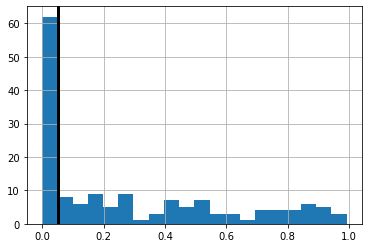

In [119]:
ax=ttest_res['pval'].hist(bins=20)
ax.axvline(0.05,color='k',linewidth=3)

In [20]:
s=width_within_bound_ratio.loc[task_index,0]
central_arm_inds = ttest_res.index.intersection(s.loc[s> 0.9].index)


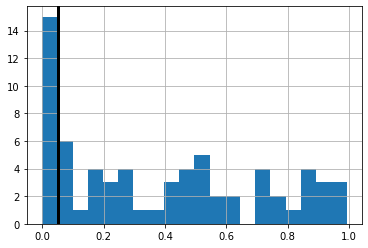

In [165]:
ax=ttest_res.loc[central_arm_inds]['pval'].hist(bins=20)
ax.axvline(0.05,color='k',linewidth=3)


In [21]:
central_splitter_index=ttest_res.loc[central_arm_inds]['pval'].loc[ttest_res.loc[central_arm_inds]['pval']<0.05].index
central_splitter_index



MultiIndex([( 91, 0),
            (121, 0),
            (166, 0),
            (173, 0),
            (188, 0),
            (190, 0),
            (193, 0),
            (207, 0),
            (233, 0),
            (245, 0),
            (278, 0),
            (297, 0),
            (379, 0),
            (398, 0),
            (428, 0)],
           )

(0.0, 100.0)

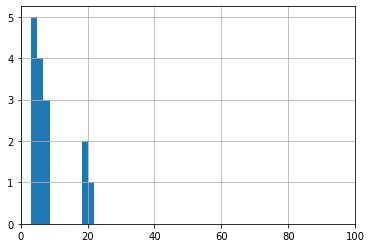

In [178]:
ax=all_fields_all_trialtype.loc[task_index,index_corresponding_trialtype_index].loc[central_splitter_index,'com'].hist()
ax.set_xlim([0,100])


In [164]:
(ttest_res.loc[central_arm_inds]['pval'] < 0.05).mean()

0.24390243902439024

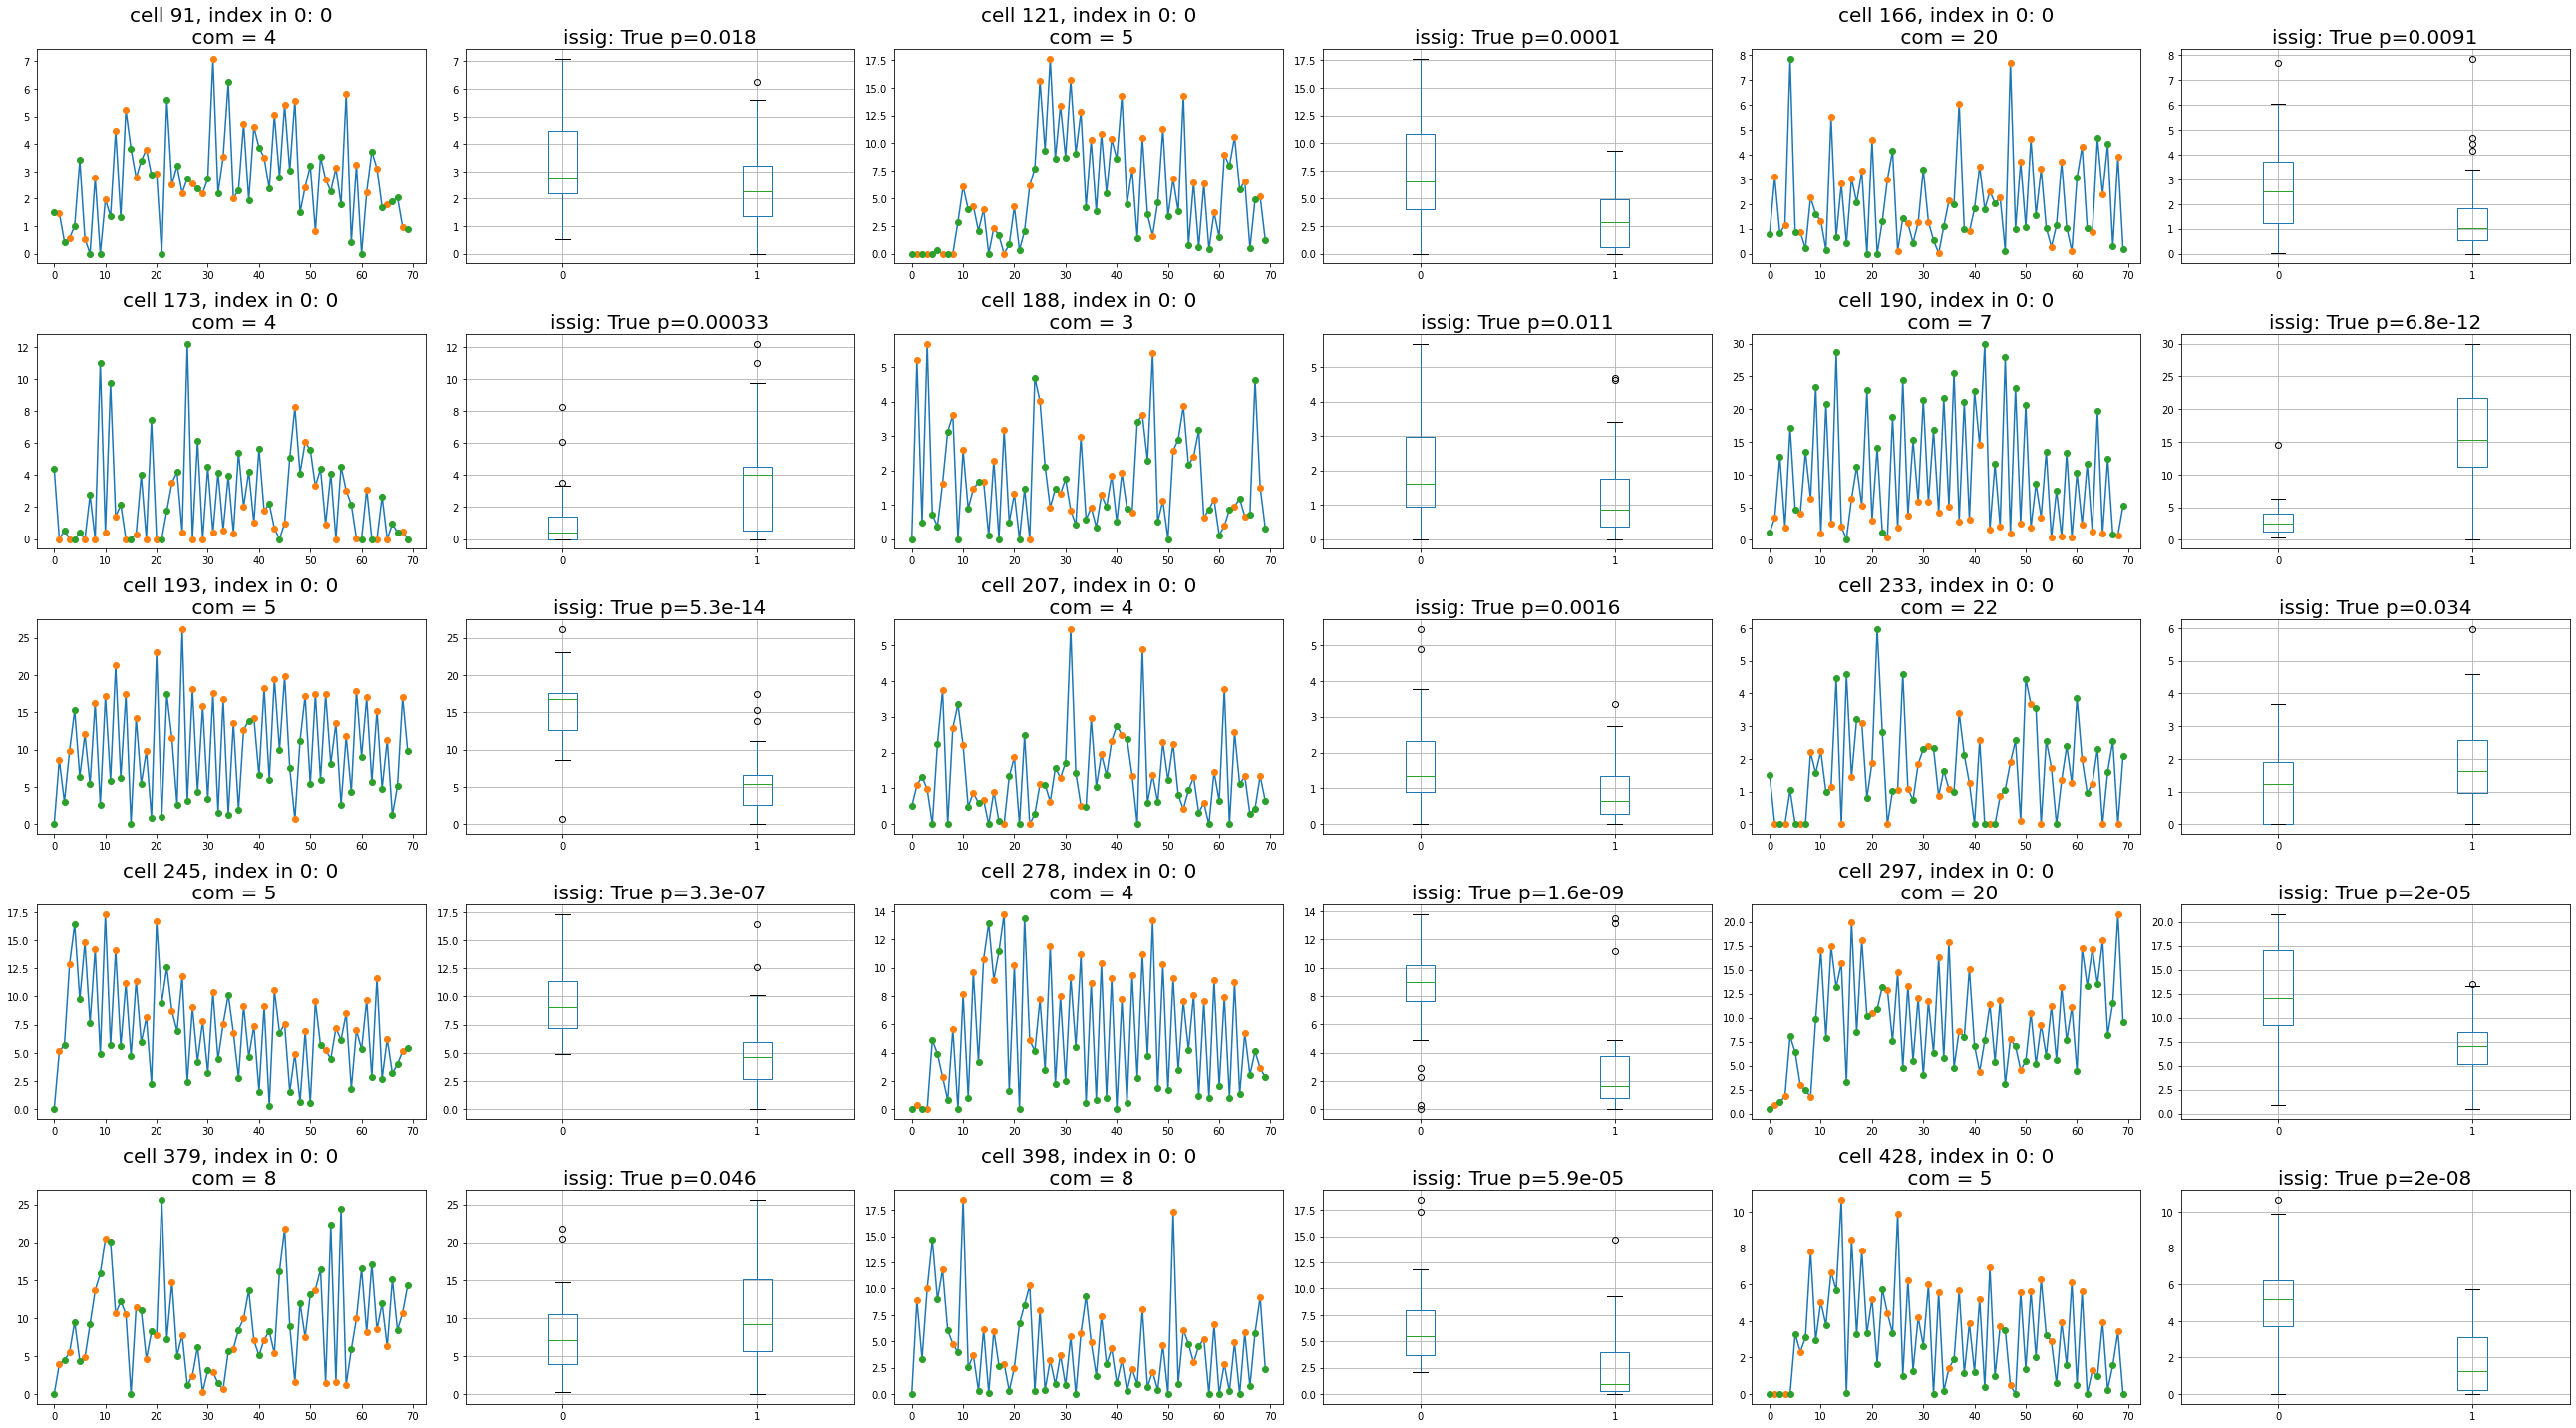

In [183]:
# nn,ff=3,0
# nn,ff = mat.index[6]

nfields_sub = len(central_splitter_index)#12
nplots = nfields_sub * 2 
st = 0
ed = st + nplots
fig,axs=ph.subplots_wrapper(nplots)

index_selected=central_splitter_index#central_arm_inds#mat.index

for ii in range(min(nfields_sub,len(index_selected))):
#     nn,ff = mat.index[st:ed][ii]
    nn,ff = index_selected[st:ed][ii]
    ax=axs.ravel()[ii * 2]
    ax_bar = axs.ravel()[ii * 2+1]
    ax=mat.loc[nn,ff].plot(ax=ax)
    tt0=mat.loc[nn,ff].loc[index_within_to_trial_index_df.loc[task_index,0]]
    tt0.plot(marker='o',linestyle='none',ax=ax)
    tt1=mat.loc[nn,ff].loc[index_within_to_trial_index_df.loc[task_index,1]]
    tt1.plot(marker='o',linestyle='none',ax=ax)
    com = all_fields_all_trialtype.loc[task_index,index_corresponding_trialtype_index].loc[(nn,ff),'com']
    ax.set_title(f'cell {nn}, index in {index_corresponding_trialtype_index}: {ff}\n com = {com}')
    
    
    pd.DataFrame({0:tt0,1:tt1}).boxplot(ax=ax_bar)
    ttest = scipy.stats.ttest_ind(tt0,tt1)
    issig=ttest[1]<0.05
    ax_bar.set_title(f'issig: {issig} p={ttest[1]:.02}')
    
plt.tight_layout()

In [42]:
task_ind=0
trialtype = 0
nn = 3
ratemap_bothtrialtype_oneneuron = fr_map_trial_df_d.loc[task_ind,slice(None),nn]

In [50]:
fr_map_concat

0    1    2    3         4    5    6    7         8   \
0 1.0   0   1.100900  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        1   1.043072  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        2   0.956631  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        3   0.861780  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        4   0.764116  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
...              ...  ...  ...  ...       ...  ...  ...  ...       ...   
  480.0 95  1.022122  0.0  0.0  0.0  0.482958  0.0  0.0  0.0  1.075058   
        96  1.282341  0.0  0.0  0.0  0.340733  0.0  0.0  0.0  0.409300   
        97  1.491263  0.0  0.0  0.0  0.209272  0.0  0.0  0.0  0.134418   
        98  1.643708  0.0  0.0  0.0  0.117377  0.0  0.0  0.0  0.037911   
        99  1.726322  0.0  0.0  0.0  0.072404  0.0  0.0  0.0  0.010921   

                  9   ...        60        61        62   63        64  \
0 1.0   0   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        1   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        2   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        3   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        4   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
...              ...  ...       ...       ...       ...  ...       ...   
  480.0 95  0.020796  ...  0.000349  0.053002  0.001748  0.0  0.002523   
        96  0.003685  ...  0.000000  0.011011  0.000000  0.0  0.000000   
        97  0.000000  ...  0.000000  0.001781  0.000000  0.0  0.000000   
        98  0.000000  ...  0.000000  0.000287  0.000000  0.0  0.000000   
        99  0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   

                  65        66        67        68        69  
0 1.0   0   0.000000  0.000000  0.000000  1.276029  0.000000  
        1   0.000000  0.000000  0.000000  1.010956  0.000000  
        2   0.000000  0.000000  0.000000  0.706983  0.000000  
        3   0.000000  0.000000  0.000000  0.500585  0.000000  
        4   0.000000  0.000000  0.000000  0.391239  0.000000  
...              ...       ...       ...       ...       ...  
  480.0 95  0.099032  0.010667  0.000109  0.001386  0.331447  
        96  0.031307  0.002283  0.000000  0.000000  0.334545  
        97  0.008732  0.000000  0.000000  0.000000  0.312716  
        98  0.002201  0.000000  0.000000  0.000000  0.284268  
        99  0.000626  0.000000  0.000000  0.000000  0.265498  

[42200 rows x 70 columns]

In [53]:
index_within_to_trial_index_df

        index
0  0.0  0         1
        1         3
        2         6
        3         8
        4        10
                 ..
   1.0  32       62
        33       64
        34       66
        35       67
        36       69
Name: 0, Length: 70, dtype: int64

In [54]:
fr_map_concat

0    1    2    3         4    5    6    7         8   \
0 1.0   0   1.100900  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        1   1.043072  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        2   0.956631  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        3   0.861780  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        4   0.764116  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
...              ...  ...  ...  ...       ...  ...  ...  ...       ...   
  480.0 95  1.022122  0.0  0.0  0.0  0.482958  0.0  0.0  0.0  1.075058   
        96  1.282341  0.0  0.0  0.0  0.340733  0.0  0.0  0.0  0.409300   
        97  1.491263  0.0  0.0  0.0  0.209272  0.0  0.0  0.0  0.134418   
        98  1.643708  0.0  0.0  0.0  0.117377  0.0  0.0  0.0  0.037911   
        99  1.726322  0.0  0.0  0.0  0.072404  0.0  0.0  0.0  0.010921   

                  9   ...        60        61        62   63        64  \
0 1.0   0   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        1   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        2   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        3   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        4   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
...              ...  ...       ...       ...       ...  ...       ...   
  480.0 95  0.020796  ...  0.000349  0.053002  0.001748  0.0  0.002523   
        96  0.003685  ...  0.000000  0.011011  0.000000  0.0  0.000000   
        97  0.000000  ...  0.000000  0.001781  0.000000  0.0  0.000000   
        98  0.000000  ...  0.000000  0.000287  0.000000  0.0  0.000000   
        99  0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   

                  65        66        67        68        69  
0 1.0   0   0.000000  0.000000  0.000000  1.276029  0.000000  
        1   0.000000  0.000000  0.000000  1.010956  0.000000  
        2   0.000000  0.000000  0.000000  0.706983  0.000000  
        3   0.000000  0.000000  0.000000  0.500585  0.000000  
        4   0.000000  0.000000  0.000000  0.391239  0.000000  
...              ...       ...       ...       ...       ...  
  480.0 95  0.099032  0.010667  0.000109  0.001386  0.331447  
        96  0.031307  0.002283  0.000000  0.000000  0.334545  
        97  0.008732  0.000000  0.000000  0.000000  0.312716  
        98  0.002201  0.000000  0.000000  0.000000  0.284268  
        99  0.000626  0.000000  0.000000  0.000000  0.265498  

[42200 rows x 70 columns]

In [136]:
def plot_ratemaps_leftright(ratemap_bothtrialtype_oneneuron_df,index_within_to_trial_index_df=None,fig=None,axs=None,markers=[7,34]):
    if axs is None:
        fig,axs = plt.subplots(1,2,sharex=True)
    cmax = ratemap_bothtrialtype_oneneuron_df.max().max() * 0.95
    cmin = 0
    if index_within_to_trial_index_df is not None:
        trial_count_ratio = [index_within_to_trial_index_df.loc[0].count(),index_within_to_trial_index_df.loc[1].count()]
        if axs is None:
            fig,axs = plt.subplots(1,2,sharex=True,height_ratios = trial_count_ratio)
            
        for ii in [0,1]:
#         for ii in [0]:
            data = ratemap_bothtrialtype_oneneuron_df.loc[:,index_within_to_trial_index_df.loc[ii].values].T
            axs[ii].imshow(data,aspect='auto',clim=(cmin,cmax))
            axs[ii].set_yticks(index_within_to_trial_index_df.loc[ii].index[::2])
            axs[ii].set_yticklabels(index_within_to_trial_index_df.loc[ii].values[::2])
#             axs[ii].yaxis.set_major_locator(MultipleLocator(2)) 
#             index_mapping = index_within_to_trial_index_df.loc[ii]
#             axs[ii].yaxis.set_major_formatter(lambda x,pos:str(index_mapping.loc[x]) if x in index_mapping.index else '')
            
            axs[ii].yaxis.set_minor_locator(MultipleLocator(1))

            
            
    else:
        trial_count_ratio = [ratemap_bothtrialtype_oneneuron_df.loc[0].dropna(axis=1).shape[1],ratemap_bothtrialtype_oneneuron_df.loc[1].dropna(axis=1).shape[1]]
        if axs is None:
            fig,axs = plt.subplots(1,2,sharex=True,height_ratios = trial_count_ratio)
        
        for ii in [0,1]:
            axs[ii].imshow(ratemap_bothtrialtype_oneneuron_df.loc[ii].T,clim=(cmin,cmax),aspect='auto')
    for ax in axs:
        if markers is not None:
            for m in markers:
                ax.axvline(m,linestyle=':')
    return fig,axs
    
    

In [57]:
ratemap_bothtrialtype_oneneuron = fr_map_concat.loc[task_ind,nn]

In [133]:
index_within_to_trial_index_df.loc[0]

     index
0.0  0         1
     1         3
     2         6
     3         8
     4        10
              ..
1.0  32       62
     33       64
     34       66
     35       67
     36       69
Name: 0, Length: 70, dtype: int64

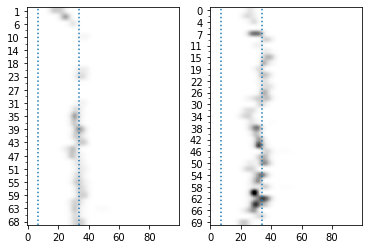

In [137]:
for ii in 
fig,axs=plot_ratemaps_leftright(ratemap_bothtrialtype_oneneuron,index_within_to_trial_index_df=index_within_to_trial_index_df.loc[task_ind])




In [141]:
fr_map_concat

0    1    2    3         4    5    6    7         8   \
0 1.0   0   1.100900  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        1   1.043072  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        2   0.956631  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        3   0.861780  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        4   0.764116  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
...              ...  ...  ...  ...       ...  ...  ...  ...       ...   
  480.0 95  1.022122  0.0  0.0  0.0  0.482958  0.0  0.0  0.0  1.075058   
        96  1.282341  0.0  0.0  0.0  0.340733  0.0  0.0  0.0  0.409300   
        97  1.491263  0.0  0.0  0.0  0.209272  0.0  0.0  0.0  0.134418   
        98  1.643708  0.0  0.0  0.0  0.117377  0.0  0.0  0.0  0.037911   
        99  1.726322  0.0  0.0  0.0  0.072404  0.0  0.0  0.0  0.010921   

                  9   ...        60        61        62   63        64  \
0 1.0   0   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        1   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        2   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        3   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        4   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
...              ...  ...       ...       ...       ...  ...       ...   
  480.0 95  0.020796  ...  0.000349  0.053002  0.001748  0.0  0.002523   
        96  0.003685  ...  0.000000  0.011011  0.000000  0.0  0.000000   
        97  0.000000  ...  0.000000  0.001781  0.000000  0.0  0.000000   
        98  0.000000  ...  0.000000  0.000287  0.000000  0.0  0.000000   
        99  0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   

                  65        66        67        68        69  
0 1.0   0   0.000000  0.000000  0.000000  1.276029  0.000000  
        1   0.000000  0.000000  0.000000  1.010956  0.000000  
        2   0.000000  0.000000  0.000000  0.706983  0.000000  
        3   0.000000  0.000000  0.000000  0.500585  0.000000  
        4   0.000000  0.000000  0.000000  0.391239  0.000000  
...              ...       ...       ...       ...       ...  
  480.0 95  0.099032  0.010667  0.000109  0.001386  0.331447  
        96  0.031307  0.002283  0.000000  0.000000  0.334545  
        97  0.008732  0.000000  0.000000  0.000000  0.312716  
        98  0.002201  0.000000  0.000000  0.000000  0.284268  
        99  0.000626  0.000000  0.000000  0.000000  0.265498  

[42200 rows x 70 columns]

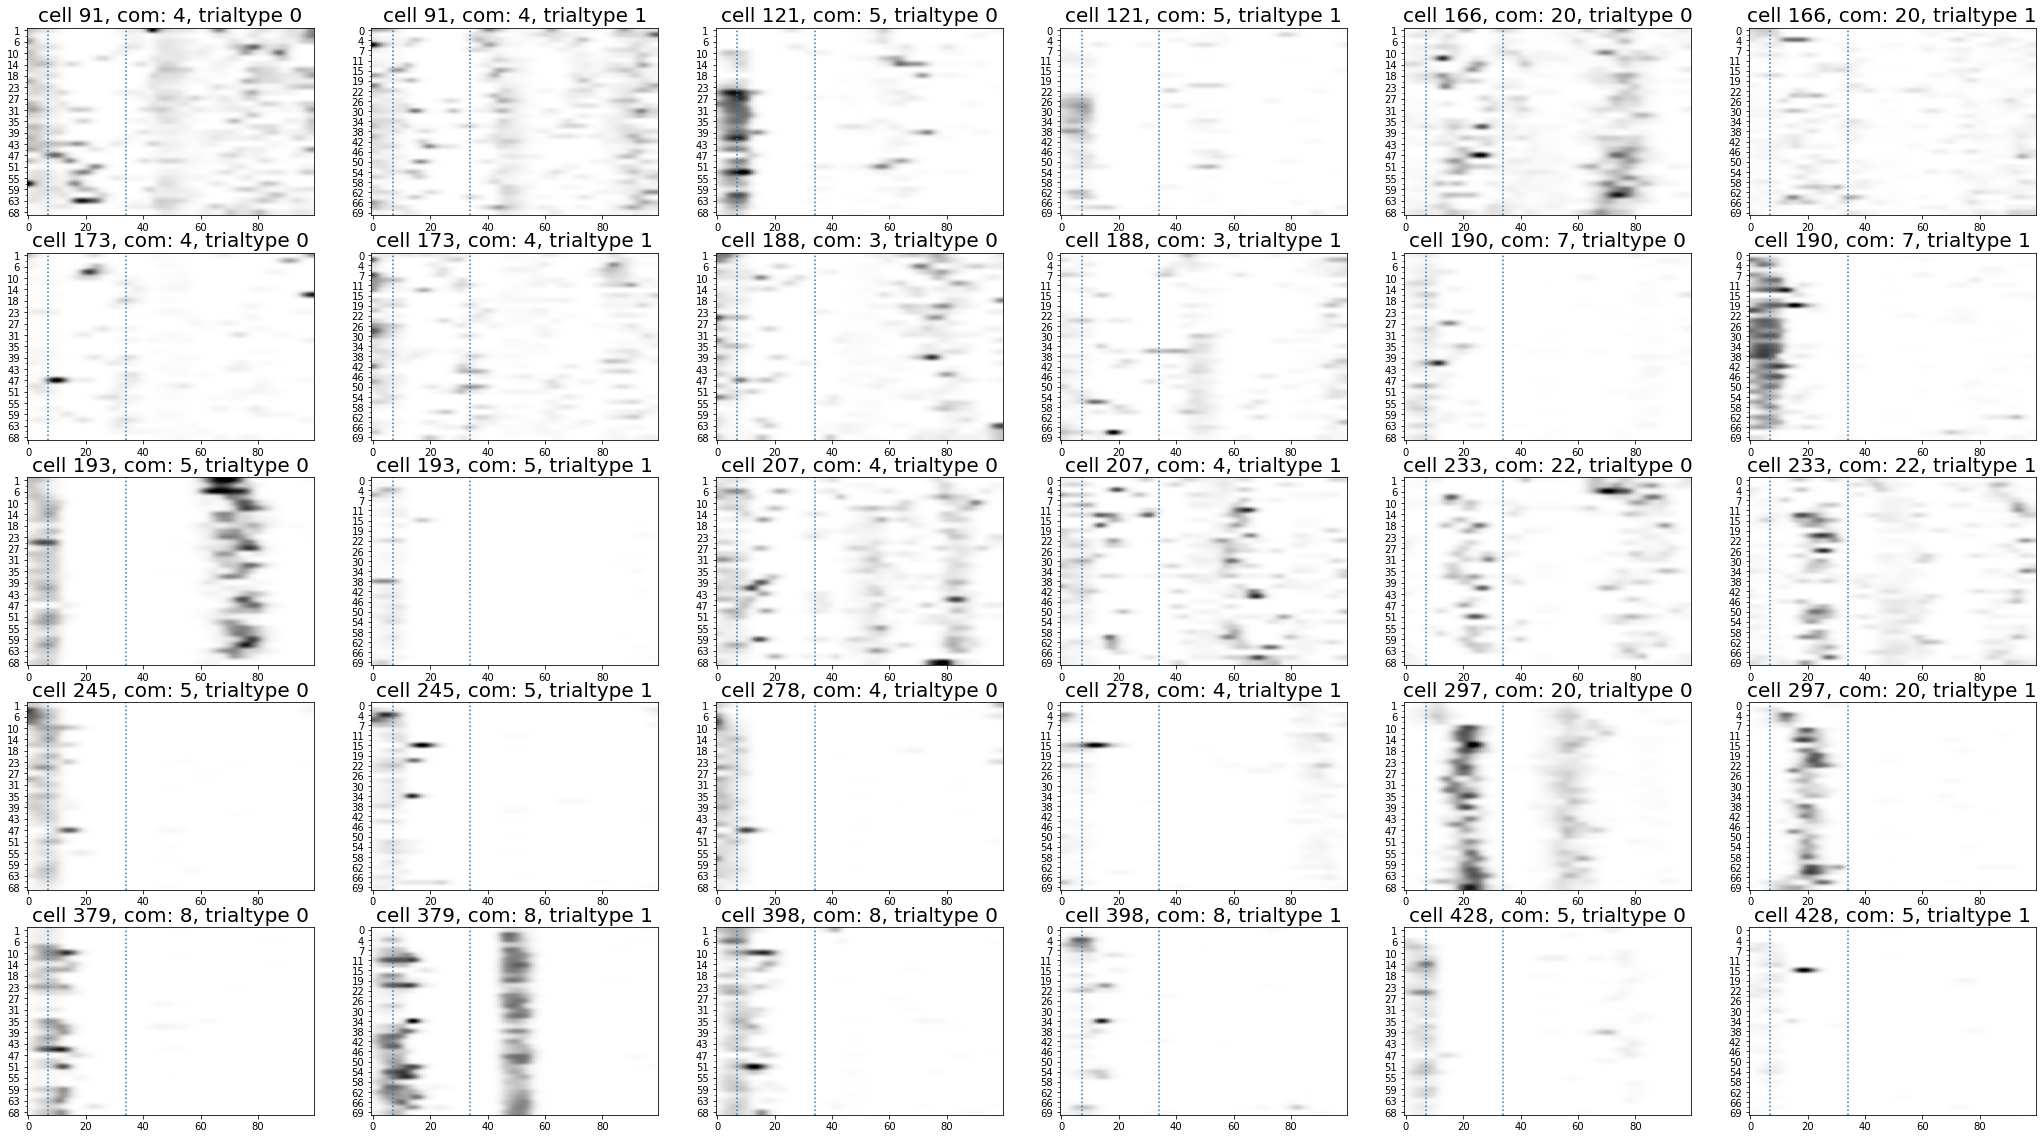

In [148]:
nfields_sub = len(central_splitter_index)#12
nplots = nfields_sub * 2 
st = 0
ed = st + nplots
fig,axs=ph.subplots_wrapper(nplots)

index_selected=central_splitter_index#central_arm_inds#mat.index

for i in range(nfields_sub):
    nn,ff =index_selected[i]
    ratemap_bothtrialtype_oneneuron = fr_map_concat.loc[task_ind,nn]
    fig,axs_sub=plot_ratemaps_leftright(ratemap_bothtrialtype_oneneuron,index_within_to_trial_index_df=index_within_to_trial_index_df.loc[task_ind],fig=fig,axs=axs.ravel()[i*2:i*2+2])
    
    com = all_fields_all_trialtype.loc[task_index,index_corresponding_trialtype_index].loc[(nn,ff),'com']
    axs_sub[0].set_title(f'cell {nn}, com: {com}, trialtype 0')
    axs_sub[1].set_title(f'cell {nn}, com: {com}, trialtype 1')
                                                    
    


In [118]:
fr_map_trial_df_d.loc[0,1].loc[nn]

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
index_mapping = index_within_to_trial_index_df.loc[0,1]

In [123]:
axs[1].imshow(fr_map_trial_df_d.loc[0,1].loc[nn].T,aspect='auto')
axs[1].yaxis.set_major_locator(MultipleLocator(2))
axs[1].yaxis.set_major_formatter(lambda x,pos:str(index_mapping.loc[x]) if x in index_mapping.index else '')
#             axs[ii].yaxis.set_major_formatter(lambda x,pos:str(x))
#             axs[ii].yaxis.set_major_formatter(temp_func)
        
axs[1].yaxis.set_minor_locator(MultipleLocator(1))

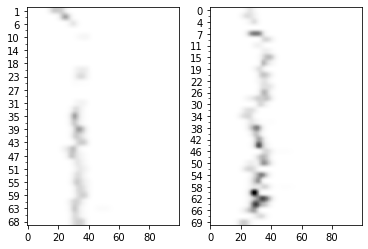

In [124]:
fig

In [75]:
index_within_to_trial_index_df

        index
0  0.0  0         1
        1         3
        2         6
        3         8
        4        10
                 ..
   1.0  32       62
        33       64
        34       66
        35       67
        36       69
Name: 0, Length: 70, dtype: int64

In [230]:
ntrials=70

In [232]:

ma = np.zeros(ntrials,dtype=bool)
ma[index_within_to_trial_index_df.loc[0,0]]=1
ma

array([False,  True, False,  True, False, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False, False,  True, False])

In [226]:
index_within_to_trial_index_df.loc[0,0]

index
0      1
1      3
2      6
3      8
4     10
5     12
6     14
7     16
8     18
9     20
10    23
11    25
12    27
13    29
14    31
15    33
16    35
17    37
18    39
19    41
20    43
21    45
22    47
23    49
24    51
25    53
26    55
27    57
28    59
29    61
30    63
31    65
32    68
Name: 0, dtype: int64

In [19]:
fr_map_concat_central = fr_map_concat.loc[(slice(None),slice(None),slice(0,34)),:]
fr_map_concat_noncentral = fr_map_concat.loc[(slice(None),slice(None),slice(34,None)),:]

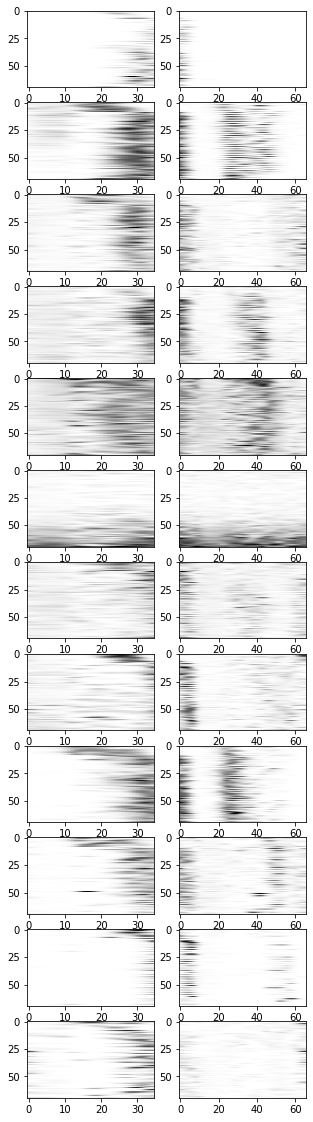

In [41]:
%matplotlib inline
start_ii=0 * 12 
end_ii = start_ii+ 12
to_plot_fields = awkward_fields.iloc[start_ii:end_ii]

fig,axs=plt.subplots(12,2,figsize=(5,20))
for ii,((ni,fi),row) in enumerate(to_plot_fields.iterrows()):
    axs[ii,0].imshow(fr_map_concat_central.loc[0,ni].T,aspect='auto')
    axs[ii,1].imshow(fr_map_concat_noncentral.loc[0,ni].T,aspect='auto')

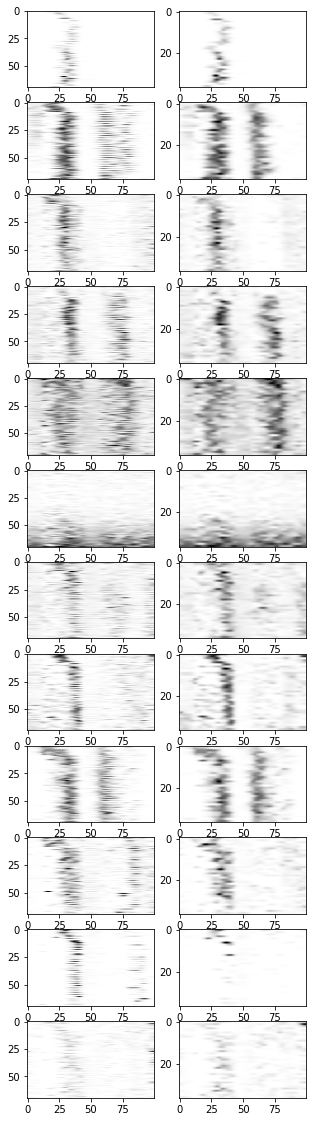

In [20]:
%matplotlib inline
start_ii=0 * 12 
end_ii = start_ii+ 12
to_plot_fields = awkward_fields.iloc[start_ii:end_ii]

fig,axs=plt.subplots(12,2,figsize=(5,20))
for ii,((ni,fi),row) in enumerate(to_plot_fields.iterrows()):
    axs[ii,0].imshow(fr_map_concat.loc[0,ni].T,aspect='auto')
    axs[ii,1].imshow(fr_map_trial_df_d.loc[0,1,ni].T,aspect='auto')

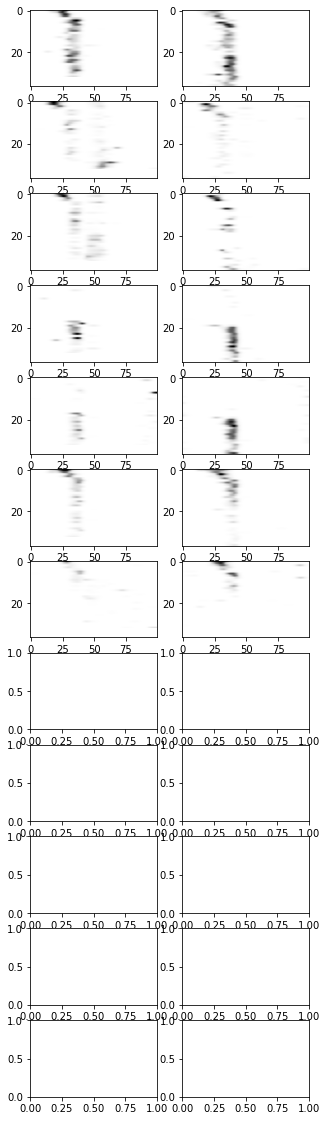

In [134]:
start_ii=2 * 12 
end_ii = start_ii+ 12
to_plot_fields = awkward_fields.iloc[start_ii:end_ii]

fig,axs=plt.subplots(12,2,figsize=(5,20))
for ii,((ni,fi),row) in enumerate(to_plot_fields.iterrows()):
    axs[ii,0].imshow(fr_map_trial_df_d.loc[0,0,ni].T,aspect='auto')
    axs[ii,1].imshow(fr_map_trial_df_d.loc[0,1,ni].T,aspect='auto')